In [ ]:
# pip installs

In [ ]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.nn import TransformerDecoder, TransformerDecoderLayer
from torch.nn import Transformer

from sklearn.model_selection import train_test_split
import statistics
from tqdm import tqdm

from sklearn import metrics
from sklearn.metrics import accuracy_score , roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

from zipfile import ZipFile

from tokenizers import Tokenizer, models, pre_tokenizers, trainers
from transformers import AutoTokenizer, AutoModelForMaskedLM

import requests
import os
import json

from torch.utils.data import Dataset, DataLoader, random_split
import random

# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

### Define seeds

In [ ]:
# define seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Data preprocessing

### here we need to load the data and extract only data with vowels punctuations

In [ ]:
# path to the jason file for the dataset
data_json_path = 'data/books.json'

# Root directory where the downloaded files will be saved
texts_path = 'data/texts'


# Create the directory if it does not exist
if not os.path.exists(texts_path):
    os.makedirs(texts_path)


# Load the json dataset
with open(data_json_path, 'r', encoding='utf-8') as f:
    jason_data = json.load(f)

# download the files and save them in a folder

#### remove\add the comment as needed

In [ ]:
# # Loop through the json dataset and download the files
# for entry in tqdm(jason_data):
#     try:
#         # Download the Nikud Meteg file
#         if entry['fileName'] + '__nikud_meteg' in os.listdir(texts_path):
#             continue
#         nikud_meteg_url = entry['nikudMetegFileURL']
#         nikud_meteg_local_path = os.path.join(texts_path, entry['fileName'] + '__nikud_meteg.zip')
#         nikud_meteg_response = requests.get(nikud_meteg_url)
#         with open(nikud_meteg_local_path, 'wb') as f:
#             f.write(nikud_meteg_response.content)

#             # Unzip the Nikud Meteg file
#             with ZipFile(nikud_meteg_local_path, 'r') as zipObj:
#                 zipObj.extractall(os.path.join(texts_path, entry['fileName'] + '__nikud_meteg'))
#     except Exception as e:
#         print(f"Error reading file {entry['fileName']}: {e}")
#         continue


# # iterate through the texts folder and delete the zip folders
# for file in tqdm(os.listdir(texts_path)):
#     if file.endswith(".zip"):
#         os.remove(os.path.join(texts_path, file))

# Author files

### Create a dictionary whose keys are authors and values are a list containing all it's files

In [ ]:
# Define a method to create the author files dictionary
def create_author_files_dict(author_files):
    """
    This function creates a dictionary of author files with a list of their corresponding texts.
    """
    author_files_dict = {}
    for file in author_files:
        author_files_dict[file] = []
        for text_file_name in os.listdir(os.path.join(texts_path, file)):
            if text_file_name.endswith('.txt'):
                author_files_dict[file].append(text_file_name)
    return author_files_dict

author_files = os.listdir(texts_path)
author_files_dict = create_author_files_dict(author_files)

# Functions to clean the data

In [ ]:
# Nikud unicode range (https://en.wikipedia.org/wiki/Unicode_and_HTML_for_the_Hebrew_alphabet)


#dictionary of nikud to name
nikud_dict = { 'ְ' : 'Sheva', 'ֱ' : 'Hataf Segol', 'ֲ' : 'Hataf Patah', 'ֳ' : 'Hataf Qamats', 'ִ' : 'Hiriq', 'ֵ' : 'Tseri', 'ֶ' : 'Segol', 'ַ' : 'Patah', 'ָ' : 'Qamats', 'ֹ' : 'Holam', 'ֻ' : 'Qubuts', 'ּ' : 'Dagesh', 'ֽ' : 'Siluk', '־' : 'Maqaf', 'ֿ' : 'Rafe', 'ׁ' : 'Shin Dot', 'ׂ' : 'Sin Dot', 'ׄ' : 'Upper Dot', 'ׅ' : 'Lower Dot', 'ׇ' : 'Point Meteg', 'װ' : 'Yiddish Double Vav', 'ױ' : 'Yiddish Vav Yod', 'ײ' : 'Yiddish Double Yod', '׳' : 'Geresh', '״' : 'Gershayim' }
# make inverse dictionary
nikud_dict_inv = {v: k for k, v in nikud_dict.items()}

# Read a txt file from the author files dictionary
def read_txt_file(file_path):
    """
    This function reads a txt file and returns the text as a string.
    """
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read()
    return text

def remove_nikud(string):
    """Removes the nikud from the given string."""
    nikud = re.compile(r'[\u0591-\u05C7]')
    return nikud.sub("", string)

def get_nikud(word):
    """Returns the nikud from the given word."""
    nikud = re.compile(r'[\u0591-\u05C7]')
    current_nikud = ''
    nikud_arr = []
    for i in range(len(word)):
        if i == 0:
            continue
        if nikud.match(word[i]):
            current_nikud += word[i]
        else:
            nikud_arr.append(current_nikud)
            current_nikud = ''
    nikud_arr.append(current_nikud)
    return nikud_arr

def add_nikud(word, nikud):
    """Adds the nikud to the given word."""
    new_word = ''
    for i in range(len(word)):
        new_word += word[i] + nikud[i]
    return new_word

def add_nikud_to_text(text, nikud):
    """Adds the nikud to the given text."""
    new_text = ''
    for word in text.split(' '):
        new_text += add_nikud(word, nikud) + ' '
    return new_text

def remove_first_char_if_nikud(word):
    """Removes the first char of the word if it is nikud."""
    nikud = re.compile(r'[\u0591-\u05C7]')
    if nikud.match(word[0]):
        return word[1:]
    return word

def get_words_indices_from_text(text):
    text_words = text.split()
    text_words_lengths = list(map(len, text_words))
    text_words_indices = [(sum(text_words_lengths[:i]), sum(text_words_lengths[:i+1])-1) for i in range(len(text_words_lengths))]
    return text_words_indices

### Test nikud functions

In [ ]:
# test the functions for adding and removing nikud
text = read_txt_file(os.path.join(texts_path, 'afikeiyam1__nikud_meteg', 'afikeiyam1-002__nikud_meteg.txt'))
# take just the first 100 characters
text = text[:100]
# remove extra spaces
text = re.sub(' +', ' ', text)
# trim text
text = text.strip()
# text_no_nikud = remove_nikud(text)
# text_nikud = get_nikud(text)
# text_with_nikud = add_nikud_to_text(text_no_nikud, text_nikud)

sentence_words = text.split()
print(f'sentence_words: {sentence_words} len: {len(sentence_words)}')
# remove the nikud from the sentence
sentence_without_nikud = remove_nikud(text)
sentence_words_without_nikud = sentence_without_nikud.split()
# get the nikud from the sentence
nikud = list(map(get_nikud, sentence_words))
print(f'nikud: {nikud} len: {len(nikud)}')
for i in range(len(sentence_words)):
    # print(f'Original word: {sentence_words[i]}')
    # print(f'Nikud: {nikud[i]}')
    # print(f'Word with nikud: {add_nikud(sentence_words_without_nikud[i], nikud[i])}')
    print(f'Original word {"==" if sentence_words[i] == add_nikud(sentence_words_without_nikud[i], nikud[i]) else "!="} word with nikud')

# sentence_with_nikud = []
# for i, word in enumerate(sentence_words):
#     sentence_with_nikud.append(add_nikud_to_text(word, nikud[i]))
# print(' '.join(sentence_with_nikud))

# print("original text:\n", text)
# print("text with added nikud:\n", text_with_nikud)
# print("text without nikud:\n", text_no_nikud)
# print("nikud array:\n", text_nikud)
# print("original is equal to text with added nikud:", text == text_with_nikud)

## Create a unified csv of all sentences

In [ ]:
import csv

#dictionary of nikud to name
nikud_dict = { 'ְ' : 'Sheva', 'ֱ' : 'Hataf Segol', 'ֲ' : 'Hataf Patah', 'ֳ' : 'Hataf Qamats', 'ִ' : 'Hiriq', 'ֵ' : 'Tseri', 'ֶ' : 'Segol', 'ַ' : 'Patah', 'ָ' : 'Qamats', 'ֹ' : 'Holam', 'ֻ' : 'Qubuts', 'ּ' : 'Dagesh', 'ֽ' : 'Siluk', '־' : 'Maqaf', 'ֿ' : 'Rafe', 'ׁ' : 'Shin Dot', 'ׂ' : 'Sin Dot', 'ׄ' : 'Upper Dot', 'ׅ' : 'Lower Dot', 'ׇ' : 'Point Meteg', 'װ' : 'Yiddish Double Vav', 'ױ' : 'Yiddish Vav Yod', 'ײ' : 'Yiddish Double Yod', '׳' : 'Geresh', '״' : 'Gershayim' }
# make inverse dictionary
nikud_dict_inv = {v: k for k, v in nikud_dict.items()}
# columns = ['text_with_nikud', 'text_without_nikud', 'nikud', 'author', 'file_name', 'sentence_num']
# with open('data/full_data_without_puncts.csv', 'w', encoding='utf-8') as f:
#     writer = csv.writer(f)
#     writer.writerow(columns)
#     for author in tqdm(author_files_dict):
#         for file in author_files_dict[author]:
#             text = read_txt_file(os.path.join(texts_path, author, file))
#             sentences = re.split(r'\n|\.', text)
#             for i, sentence in enumerate(sentences):
#                 sentence = re.sub('\'|\"|\(|\)', '', sentence)
#                 # Remove Dagesh, Shin Dot, Sin Dot using nikud_dict_inv
#                 sentence = re.sub(nikud_dict_inv['Dagesh'], '', sentence)
#                 sentence = re.sub(nikud_dict_inv['Shin Dot'], '', sentence)
#                 sentence = re.sub(nikud_dict_inv['Sin Dot'], '', sentence)
#                 # Keep only the nikud and hebrew letters and spaces
#                 sentence = re.sub(r'[^א-ת' + ''.join(nikud_dict.keys()) + '\s]', '', sentence)
#                 # remove multiple spaces
#                 sentence = re.sub(r'\s+', ' ', sentence)
#                 sentence = sentence.strip()
#                 if sentence == '':
#                     continue
#                 # split the sentence into words
#                 sentence_words = sentence.split()
#                 # remove the nikud from the sentence
#                 sentence_without_nikud = remove_nikud(sentence)
#                 # make sure first char is not in [\u0591-\u05C7]
#                 sentence_words = list(map(remove_first_char_if_nikud, sentence_words))
#                 sentence_words = [word for word in sentence_words if word != '']
#                 # get the nikud from the sentence
#                 nikud = list(map(get_nikud, sentence_words))
            
#                 flag = True
#                 no_nikud_words = sentence_without_nikud.split()
#                 for j in range(len(no_nikud_words)):
#                     if sentence_words[j] != add_nikud(no_nikud_words[j], nikud[j]):
#                         test_word = sentence_words[j]
#                         flag = False
#                         print('No match')
                            
#                 # add the sentence to the dataframe
#                 writer.writerow([sentence, sentence_without_nikud, nikud, author, file, i])

#### load the data from the csv for chuncks and save first chunck in json for short data

In [ ]:
# #read only first 100000 rows of the CSV, we will use this for now
# data_df = pd.read_csv('data/full_data_without_puncts.csv', nrows=200000, converters={'nikud': eval})
# print(data_df.head())

# # keep only rows s.t the length of the text (without spaces) is at most 100
# data_df = data_df[data_df['text_without_nikud'].str.replace(' ', '').str.len() <= 100]

# # save the dataframe to a json file
# data_df.to_json('data/full_data_without_puncts.json', orient='records', lines=True)

##### read the json short data

In [ ]:
# read the json file
data_df = pd.read_json('data/full_data_without_puncts.json', orient='records', lines=True, nrows=55000)
print(data_df.shape)

In [ ]:
# DELETE this block, only for debugging make the data smaller (randomly select 5000 rows)
data_df = data_df.sample(n=5000, random_state=1)
print(data_df.shape)

In [ ]:
""" block explanation
# This block loops through each row in the data_df dataframe, reconstructs the original sentence with nikud, and compares it to the original sentence.
# If the reconstructed sentence is not the same as the original text, it prints debugging information and checks character by character to find where the two strings differ.
"""


# Loop through each row in the data_df dataframe
for i in range(len(data_df)):
    
    # Get the original text, processed text, and nikud for the current row
    original_text = data_df.iloc[i]['text_with_nikud']
    processed_text = data_df.iloc[i]['text_without_nikud'].split()
    nikud = data_df.iloc[i]['nikud']
    
    # Initialize an empty string to hold the reconstructed sentence
    sentence = ''
    
    # Loop through each word in the processed text and add the corresponding nikud
    for j in range(len(processed_text)):
        sentence += add_nikud(processed_text[j], nikud[j]) + ' '
    
    # Remove the last space from the sentence
    sentence = sentence[:-1]
    
    # If the reconstructed sentence is not the same as the original text, print some debugging information
    if original_text.strip(' ') != sentence:
        print('Original text:\n', original_text.strip(' '))
        print('Original text length: ', len(original_text.strip(' ')))
        print('Processed text:\n', sentence)
        print('Processed text length: ', len(sentence))
        
        # Check character by character to find where the two strings differ
        for k in range(len(original_text.strip(' '))):
            if original_text.strip(' ')[k] != sentence[k]:
                print('Character: ', original_text.strip(' ')[k])
                print('Character: ', sentence[k])
                print('Index: ', k)
                break
        
        print('-----------------------------------')
        break


#### Define dictionary label_to_id and id_to_label


In [ ]:
label_to_id = {'<no_nikud>': 0}
id_to_label = {0: '<no_nikud>'}
for label_list in tqdm(data_df['nikud']):
    # flatten the list
    label_list = [item for sublist in label_list for item in sublist]
    for label in label_list:
        if len(label) == 0:
            label = "<no_nikud>"
        if label not in label_to_id:
            label_to_id[label] = len(label_to_id)
            id_to_label[len(id_to_label)] = label

print(label_to_id)



#### count labels for label_weights

In [ ]:
# Count the number of each label
label_count = {}
for label_list in tqdm(data_df['nikud']):
    # Flatten the list
    label_list = [item for sublist in label_list for item in sublist]
    for label in label_list:
        if len(label) == 0:
            label = "<no_nikud>"
        if label not in label_count:
            label_count[label] = 0
        label_count[label] += 1

print(label_count)

# Plot counts of each label (sorted)
sorted_labels = sorted(label_count.items(), key=lambda x: x[1], reverse=True)
print(sorted_labels)
plt.figure(figsize=(8, 4))
plt.xticks(rotation=90)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Counts')
plt.bar([x[0] for x in sorted_labels], [x[1] for x in sorted_labels])
plt.show()

# Define the label weights
label_weights = {}
for label in label_count:
    if label == "<no_nikud>":
        label_weights[label] = 0.33
    else:
        label_weights[label] = 1

# Normalize the weights
sum_weights = sum(label_weights.values())
for label in label_weights:
    label_weights[label] /= sum_weights

def set_no_nikud_weight(weight=0.33):
    label_weights = {}
    for label in label_count:
        if label == "<no_nikud>":
            label_weights[label] = weight
        else:
            label_weights[label] = 1
    sum_weights = sum(label_weights.values())
    for label in label_weights:
        label_weights[label] /= sum_weights
    return label_weights
        

print(label_weights)

for label in label_weights.keys():
    if label == "<no_nikud>":
        print(f'f label name = {label}')
    elif len(label) == 1:
        print(f'label name = {nikud_dict[label]}')
    else:
        label_name = ""
        for char in label:
            label_name += " " + nikud_dict[char]
        print(f'label name = {label_name}')
    

### EDA - DataAnalysis on short_df

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain

class DataAnalysis:
    def __init__(self, data_df):
        self.data_df = data_df.copy()
        
    def author_distribution(self):
        # Distribution of authors
        author_distribution = self.data_df['author'].value_counts()

        # Bar plot of the distribution of the top 20 authors
        plt.figure(figsize=(10, 6))
        author_distribution[:20].plot(kind='bar')
        plt.xlabel('Author')
        plt.ylabel('Frequency')
        plt.title('Top 20 Authors')
        plt.xticks(rotation=90)
        plt.show()
        
    def file_distribution(self):
        # Distribution of files
        file_distribution = self.data_df['file_name'].value_counts()

        # Bar plot of the distribution of the top 20 files
        plt.figure(figsize=(10, 6))
        file_distribution[:20].plot(kind='bar')
        plt.xlabel('File')
        plt.ylabel('Frequency')
        plt.title('Top 20 Files')
        plt.xticks(rotation=90)
        plt.show()
        
    def sentence_length_distribution(self):
        # Create a new column for sentence length
        self.data_df['sentence_length'] = self.data_df['text_without_nikud'].str.split().str.len()

        # Get the distribution of sentence lengths
        sentence_length_distribution = self.data_df['sentence_length'].value_counts().sort_index()

        # Histogram of the distribution of sentence lengths
        plt.figure(figsize=(10, 6))
        plt.hist(self.data_df['sentence_length'], bins=50, alpha=0.5)
        plt.xlabel('Sentence Length')
        plt.ylabel('Frequency')
        plt.title('Distribution of Sentence Lengths')
        plt.show()
        
    def common_words(self):
        # Tokenize the sentences
        tokenized_sentences = self.data_df['text_without_nikud'].str.split()

        # Flatten the list of tokens and count the frequency of each token
        word_counts = Counter(chain.from_iterable(tokenized_sentences))

        # Get the 20 most common words
        common_words = word_counts.most_common(20)

        # Bar plot of the frequency of the 20 most common words
        plt.figure(figsize=(10, 6))
        words, counts = zip(*common_words)
        plt.bar(words, counts)
        plt.xlabel('Word')
        plt.ylabel('Frequency')
        plt.title('20 Most Common Words')
        plt.xticks(rotation=90)
        plt.show()
        
    def common_nikud(self):
        # Flatten the list of Nikud and count the frequency of each Nikud
        nikud_counts = Counter(chain.from_iterable(chain.from_iterable(self.data_df['nikud'])))

        # Get the 20 most common Nikud
        common_nikud = nikud_counts.most_common(20)

        # Bar plot of the frequency of the 20 most common Nikud
        plt.figure(figsize=(10, 6))
        nikud, counts = zip(*common_nikud)
        plt.bar(nikud, counts)
        plt.xlabel('Nikud')
        plt.ylabel('Frequency')
        plt.title('20 Most Common Nikud')
        plt.xticks(rotation=90)
        plt.show()

# instantiate the class and call the methods
# data_analysis = DataAnalysis(data_df)
# data_analysis.author_distribution()
# data_analysis.file_distribution()
# data_analysis.sentence_length_distribution()
# data_analysis.common_words()
# data_analysis.common_nikud()


#### download tokenizer and model
(alephbert-base, with vocab of words with len <= 1)

In [ ]:
model_path = 'C:\\Users\\baruc\\PycharmProjects\\pythonProject\\Punctuation_Restoration\\AlephBERT-main\\AlephBERT-main\\models\\alephbert-base'
alephbert_tokenizer = AutoTokenizer.from_pretrained(model_path)
alephbert_model = AutoModelForMaskedLM.from_pretrained("onlplab/alephbert-base")

In [ ]:
# test the tokenization and detokenization
test = "בדיקה של הדבר הזה"
tokenized = alephbert_tokenizer.tokenize(test)
encoded = alephbert_tokenizer.encode(test)
decoded = alephbert_tokenizer.decode(encoded)
print(test)
print("tokenized: ", tokenized)
print("encoded: ", encoded)
print("decoded: ", decoded)

In [ ]:
data_df.iloc[0]
text = data_df.iloc[0]['text_without_nikud']
nikud = data_df.iloc[0]['nikud']
for row in data_df.iterrows():
    text = row[1]['text_without_nikud']
    text_with_nikud = row[1]['text_with_nikud']
    nikud = row[1]['nikud']
    text_words = text.split()
    sentence = []
    for i in range(len(nikud)):
        sentence.append(add_nikud(text_words[i], nikud[i]))
    sentence = ' '.join(sentence)
    if sentence != text_with_nikud:
        print(sentence)
        print(text_with_nikud)
        print('------------------')

# create DataSet class

In [ ]:
# create pytorch dataset class for punctuation restoration (returns input(text) and target(nikud))

class PunctuationRestorationDataset(Dataset):
    def __init__(self, data_df, tokenizer, label_to_id, max_len):
        self.data = data_df
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.label_to_id = label_to_id 
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index): # TODO: need to make sure not to look at fraction of words
        text = self.data.iloc[index]['text_without_nikud']
        nikud = self.data.iloc[index]['nikud']  # list of lists of nikud

        # flatten nikud list
        nikud = [item for sublist in nikud for item in sublist]
        # replace empty strings with <no_nikud> token
        nikud = [label if label != "" else "<no_nikud>" for label in nikud]
        # replace labels with ids
        nikud = [self.label_to_id[label] for label in nikud]

        # check if nikud length is the same as text without spaces length
        if len(text.replace(" ", "")) != len(nikud):
            print("text without spaces length: ", len(text.replace(" ", "")))
            print("nikud length: ", len(nikud))
        
        # get word indices after tokenization
        word_indices = get_words_indices_from_text(text)
        # pad word_indices to be the same length as input_ids
        word_indices = word_indices + [(-1, -1)] * (self.max_len - len(word_indices))
        # convert word_indices to tensor
        word_indices = torch.tensor(word_indices, dtype=torch.long)

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=False,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        # pad nikud to be the same length as input_ids
        nikud = nikud + [len(label_to_id)] * (encoding['input_ids'].shape[1] - len(nikud))
        # convert to tensor
        nikud = torch.tensor(nikud, dtype=torch.long)
        
        return {
            'text': text,
            'nikud': nikud,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'word_indices': word_indices
        }


# create pytorch dataset class for punctuation restoration (returns input(text) and target(nikud))
dataset = PunctuationRestorationDataset(data_df, alephbert_tokenizer, label_to_id, 100)
print("dataset length: ", len(dataset))




In [66]:
# #iterate over dataset
for i in range(len(dataset)):
    sample = dataset[i]
    Original = data_df.iloc[i]['text_with_nikud']
    text_without_nikud = sample['text']
    nikud = sample['nikud']
    input_ids = sample['input_ids']
    attention_mask = sample['attention_mask']
    word_indices = sample['word_indices']
    
    # convert nikud_id to nikud_label
    nikud_after_id_to_label = [id_to_label[id] if id < len(id_to_label) else "<no_nikud>" for id in nikud.tolist()]
    # add nikud to text without nikud
    text_words = text_without_nikud.split()
    text_words_with_nikud = []
    for word_index, word in enumerate(text_words):
        text_words_with_nikud.append(add_nikud(word, nikud_after_id_to_label[word_indices[word_index][0]:word_indices[word_index][1]+1]))
    text_with_nikud = " ".join(text_words_with_nikud)
    text_with_nikud = text_with_nikud.replace("<no_nikud>", "")
    if text_with_nikud != Original:
        print("text_with_nikud: ", text_with_nikud)
        print("Original: ", Original)
    print("word_indices: ", word_indices)
    # convert input_ids to tokens
    tokens = alephbert_tokenizer.convert_ids_to_tokens(input_ids)
    if i > 5:
        break
    
    # # Check that nikud alligns with tokens
    # nikud = nikud.tolist()
    # # zip tokens and nikud
    # tokens_with_nikud = list(zip(tokens, nikud))
    # # print("tokens_with_nikud: ", tokens_with_nikud)
    # for token, label in tokens_with_nikud:
    #     if token == "[PAD]" and label != len(id_to_label) or token != "[PAD]" and label == len(id_to_label):
    #         print("token: ", token)
    #         print("label: ", label)
                


word_indices:  tensor([[ 0,  3],
        [ 4,  6],
        [ 7,  9],
        [10, 12],
        [13, 13],
        [14, 18],
        [19, 21],
        [22, 24],
        [25, 27],
        [28, 30],
        [31, 34],
        [35, 37],
        [38, 41],
        [42, 44],
        [45, 47],
        [48, 51],
        [52, 54],
        [55, 56],
        [57, 60],
        [61, 64],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, 

#### split to train,val and test datasets and dataloaders

In [ ]:
# split dataset to train, val and test
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

batch_size = 32

# create dataloader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)



# performe EDAs on the data

In [ ]:
# EDA on train, val and test dataset
print("train dataset size: ", len(train_dataset))
print("val dataset size: ", len(val_dataset))
print("test dataset size: ", len(test_dataset))

# train dataset
print("train dataset type: ", type(train_dataset))
print("train dataset[0] type: ", type(train_dataset[0]))
print("train dataset[0] keys: ", train_dataset[0].keys())

# Define the two models (one with look-ahead, one without)

### train the two models

### Evaluate the models

## Full-Sentence Model

In [ ]:
# define a charachter level transformer model with the following architecture:
# 1. Embedding layer
# 2. Transformer layer
# 3. Fully connected layer

embedding_dim = 1024

class FullSentenceModel(nn.Module):
    """ Transformer model for Nikud restoration. """
    def __init__(self, vocab_size, embedding_dim=512, nhead=8, num_layers=6, output_dim=len(label_to_id), dropout=0.1):
        super(FullSentenceModel, self).__init__()
        
        # Non-pretrained embedding layer
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim, padding_idx=0)
        
        self.transformer = nn.Transformer(d_model=embedding_dim, nhead=nhead, num_encoder_layers=num_layers, num_decoder_layers=num_layers, dropout=dropout, activation='relu')

        # try with just encoder
        #self.transformer = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=nhead, dropout=dropout), num_layers=num_layers)

        self.fc = nn.Linear(embedding_dim, output_dim)
        

    def forward(self, sentence):
        # Pass input through embedding layer
        characters_embeddings = self.embedding(sentence)
        
        # Pass through transformer
        characters_after_transformer_layers = self.transformer(characters_embeddings, characters_embeddings)
        #characters_after_transformer_layers = self.transformer(characters_embeddings)
        
        # Pass through fully connected layer
        predictions = self.fc(characters_after_transformer_layers)
        
        return predictions
    


In [ ]:
from torch.optim.lr_scheduler import StepLR

vocab_size = len(alephbert_tokenizer.vocab)

# criterion = nn.CrossEntropyLoss(ignore_index=len(label_to_id)).to(device)
weights = torch.tensor(list(label_weights.values())).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=len(label_to_id), weight=weights).to(device)

train_loss_history = []
val_loss_history = []


# define the training loop
def train_full_model(model, dataloader, optimizer, criterion):
    model.train()
    epoch_loss = 0
    for batch in tqdm(dataloader):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        labels = batch['nikud'].to(device)
        predictions = model.forward(input_ids)#, labels)
        predictions = predictions.view(-1, predictions.shape[-1])
        labels = labels.view(-1)

        # # convert labels of no_nikud to ignore_index (padding index)
        # labels[labels == label_to_id['<no_nikud>']] = len(label_to_id)

        loss = criterion(predictions, labels)
        train_loss_history.append(loss.item())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(dataloader)

# define the evaluation loop
def evaluate_full_model(model, dataloader, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for batch in tqdm(dataloader):
            input_ids = batch['input_ids'].to(device)
            labels = batch['nikud'].to(device)
            predictions = model.forward(input_ids)
            predictions = predictions.view(-1, predictions.shape[-1])
            labels = labels.view(-1)
            loss = criterion(predictions, labels)
            val_loss_history.append(loss.item())
            epoch_loss += loss.item()
    return epoch_loss / len(dataloader)

# define the training and evaluation loop
def train_and_evaluate_full_model(model, train_dataloader, val_dataloader, optimizer, criterion, epochs=5):
    for epoch in range(epochs):
        train_loss = train_full_model(model, train_dataloader, optimizer, criterion)
        scheduler.step()
        val_loss = evaluate_full_model(model, val_dataloader, criterion)
        print(f'Epoch: {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        # plot train and val loss history
        plt.plot(train_loss_history, label='train')
        plt.plot(val_loss_history, label='val')
        plt.legend()
        plt.show()


def hyperparameter_grid_search():
    # train the model
    nhead = [2, 4, 8]
    nlayers = [2, 4, 6]
    lr = [0.0001, 0.00001]
    for n in nhead:
        for l in nlayers:
            for r in lr:
                model = FullSentenceModel(vocab_size, nhead=n, num_layers=l).to(device)
                optimizer = torch.optim.Adam(model.parameters(), lr=r)
                print(f'nhead: {n}, nlayers: {l}, lr: {r}')
                train_and_evaluate_full_model(model, train_loader, val_loader, optimizer, criterion, epochs=5)

# Imprortant reminder: Optimizer should be defined for each model separately
# model = FullSentenceModel(vocab_size, nhead=8, num_layers=6, embedding_dim=512).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# # Define AdamW optimizer
# # optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
# scheduler = StepLR(optimizer, step_size=1, gamma=0.9)

# print number of trainable parameters
# print(f'Number of trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}')

label_weights_list = [0.5]#, 0.5, 0.33, 0.25]
for weight in label_weights_list:
    train_loss_history = []
    print(f'Starting weight: {weight}')
    model = FullSentenceModel(vocab_size, nhead=8, num_layers=6, embedding_dim=512).to(device)
    print(f'Number of trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}')
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    # Define AdamW optimizer
    # optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
    scheduler = StepLR(optimizer, step_size=1, gamma=0.9)
    label_weights = set_no_nikud_weight(weight)
    weights = torch.tensor(list(label_weights.values())).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=len(label_to_id), weight=weights).to(device)
    train_and_evaluate_full_model(model, train_loader, val_loader, optimizer, criterion, epochs=2)
    print(f'Finished weight: {weight}')
    print('-----------------------------------')




In [ ]:
# plot train and val loss
plt.plot(train_loss_history, label='train')
plt.plot(val_loss_history, label='val')
plt.legend()
plt.show()




In [ ]:
for batch in test_loader:
    # predict on the first batch of the test set
    model.eval()
    with torch.no_grad():
        input_ids = batch['input_ids'].to(device)
        labels = batch['nikud'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        word_indices = batch['word_indices'].to(device)
        
        # print some information about the batch
        # print("number of zeros in input_ids: ", torch.sum(input_ids == 0))
        # print("number of 0 in attention_mask: ", torch.sum(attention_mask == 0))
        # print("number of paddings in labels: ", torch.sum(labels == len(id_to_label)))

        # convert the input_ids to tokens
        tokens = alephbert_tokenizer.convert_ids_to_tokens(input_ids[0])
        # enumerate the tokens and their ids and save them in a dictionary
        token_ids = {i: token for i, token in enumerate(zip(input_ids[0].tolist(), tokens))}
        # save token_ids in a dataframe
        token_ids_df = pd.DataFrame.from_dict(token_ids, orient='index', columns=['id', 'token'])
        # add the labels to the dataframe
        token_ids_df['label'] = labels[0].tolist()
        
        # make sure ['PAD'] recieved the correct label
        if not (token_ids_df[token_ids_df['token'] == '[PAD]']['label'] == len(id_to_label)).all():
            print("ERROR")
        
        # get the model's predictions and calculate the loss
        predictions = model.forward(input_ids)
        predictions = predictions.view(-1, predictions.shape[-1])
        labels = labels.view(-1)
        word_indices = word_indices.view(-1, 2)

        loss = criterion(predictions, labels)
        
        # print some information about the predictions
        print("input_ids: ", input_ids)
        print("labels: ", labels)
        print("attention_mask: ", attention_mask)
        print(f'Predictions shape: {predictions.shape}')
        print("predictions: ", predictions)
        print(f'Loss: {loss.item():.4f}')
        
        # remove the padding tokens from the predictions and labels
        predictions = predictions[attention_mask.view(-1) == 1]
        
        labels = labels[attention_mask.view(-1) == 1]
        word_indices = word_indices[word_indices[:, 0] != -1]
        print(f'Predictions shape: {predictions.shape}')
        print(f'Labels shape: {labels.shape}')
        
        # get the top 2 predictions for each token
        predictions = torch.topk(predictions, k=2, dim=1).indices
        first_prediction = predictions[:, 0]
        second_prediction = predictions[:, 1]

        # calculate the accuracy of the model's predictions
        correct_sum = 0
        overall_sum = 0
        for i in range(len(first_prediction)):
            if first_prediction[i] != 0:
                overall_sum += 1
                if first_prediction[i] == labels[i]:
                    correct_sum += 1
        accuracy = correct_sum / overall_sum
        print(f'Accuracy of actual nikud: {accuracy:.4f}')
        
        overall_sum = torch.sum(first_prediction == labels)
        
        # calculate the overall accuracy of the model's predictions
        accuracy = overall_sum / len(labels)
        print(f'Accuracy: {accuracy.item():.4f}')
        
        # print the model's predictions and the actual labels for the first 50 tokens
        print("Predictions\tLabels\t\tFirst\t\tSecond\t\tChar")
        for i in range(100):
            if token_ids_df.iloc[i]["token"] == '[PAD]':
                break
            print(f'{predictions[i].tolist()}\t\t{labels[i]}\t\t{predictions[i].tolist()[0] == labels[i]}\t\t{predictions[i].tolist()[1] == labels[i]}\t\t{token_ids_df.iloc[i]["token"]}')
        break


#### Reading-Direction Model

In [ ]:
class ReadingDirectionModel(nn.Module):
    def __init__(self, char_vocab_size, num_labels, char_embedding_dim=32, word_hidden_dim=16, char_hidden_dim=512, num_layers=4):
        super(ReadingDirectionModel, self).__init__()
        
        self.word_hidden_dim = word_hidden_dim
        
        # Character Embedding Layer
        self.char_embedding = nn.Embedding(char_vocab_size, char_embedding_dim)
        
        # Word-Level BiLSTM
        self.word_bilstm = nn.LSTM(char_embedding_dim, word_hidden_dim, bidirectional=True, batch_first=True)
        
        # Character-Level LSTM
        self.char_lstm = nn.LSTM(input_size=char_embedding_dim + 2 * word_hidden_dim, hidden_size=char_hidden_dim, batch_first=True, num_layers=num_layers)

        
        # Fully Connected Layer
        self.fc = nn.Linear(char_hidden_dim, num_labels)
        
        # Dropout Layer
        self.dropout = nn.Dropout(0.2)

    def forward(self, char_sequence, word_boundaries):
        # Apply Character Embedding
        char_embedded = self.char_embedding(char_sequence)
        
        # Process each word using the Word-Level BiLSTM
        word_embeddings_list = []
        for i in range(len(char_sequence)):
            word_embedding_for_sample = []
            for boundaries in word_boundaries[i]:
                start, end = boundaries
                if start == -1:
                    break
                word_seq = char_embedded[i, start:end+1, :]
                word_seq_output, _ = self.word_bilstm(word_seq.unsqueeze(0))
                word_embedding = torch.cat((word_seq_output[0, -1, :self.word_hidden_dim], 
                                            word_seq_output[0, 0, self.word_hidden_dim:]), dim=0)
                word_embedding_for_sample.append(word_embedding)
            word_embeddings_list.append(torch.stack(word_embedding_for_sample))
        
        # Pad the word embeddings to the same length as the input sequence
        max_length = char_embedded.size(1)
        padded_word_embeddings_list = []
        for embed in word_embeddings_list:
            padding_length = max_length - embed.size(0)
            padding = torch.zeros(padding_length, embed.size(1)).to(embed.device)
            padded_embed = torch.cat([embed, padding], dim=0)
            padded_word_embeddings_list.append(padded_embed)
        word_embeddings_tensor = torch.stack(padded_word_embeddings_list, dim=0)
        
        # Concatenate the character embeddings with the word embeddings
        char_word_embedded = torch.cat([char_embedded, word_embeddings_tensor], dim=2)
        
        # Apply Character-Level LSTM
        char_lstm_output, _ = self.char_lstm(char_word_embedded)
        
        # Apply Dropout
        char_lstm_output = self.dropout(char_lstm_output)
        
        # Apply Fully Connected Layer
        predictions = self.fc(char_lstm_output)
        
        return predictions
    



In [79]:
def train_directional_model(model, train_loader, optimizer, criterion, train_directional_model_loss_history):
    model.train()
    total_loss = 0
    total_correct = 0
    total_overall = 0
    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].to(device)
        word_indices = batch['word_indices'].to(device)
        labels = batch['nikud'].to(device)
        optimizer.zero_grad()
        predictions = model.forward(input_ids, word_indices)
        loss = criterion(predictions.view(-1, predictions.shape[-1]), labels.view(-1))
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        train_directional_model_loss_history.append(loss.item())
        
        attention_mask = batch['attention_mask']
        predictions = predictions.view(-1, predictions.shape[-1])
        labels = labels.view(-1)
        predictions = predictions[attention_mask.view(-1) == 1]
        labels = labels[attention_mask.view(-1) == 1]
        predictions = torch.argmax(predictions, dim=1)

        # calculate accuracy
        pre = predictions.cpu().numpy()
        lab = labels.cpu().numpy()
        total_correct += np.sum(pre == lab)
        total_overall += len(pre)
    accuracy = total_correct / total_overall
    return total_loss / len(train_loader), accuracy

# Define evaluate method
def evaluate_directional_model(model, eval_loader, criterion, val_directional_model_loss_history):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_overall = 0
    with torch.no_grad():
        for batch in tqdm(eval_loader):
            input_ids = batch['input_ids'].to(device)
            word_indices = batch['word_indices'].to(device)
            labels = batch['nikud'].to(device)
            predictions = model.forward(input_ids, word_indices)
            loss = criterion(predictions.view(-1, predictions.shape[-1]), labels.view(-1))
            total_loss += loss.item()
            # total_correct += (predictions.argmax(2) == labels).sum().item()
            val_directional_model_loss_history.append(loss.item())

            attention_mask = batch['attention_mask']
            predictions = predictions.view(-1, predictions.shape[-1])
            labels = labels.view(-1)
            predictions = predictions[attention_mask.view(-1) == 1]
            labels = labels[attention_mask.view(-1) == 1]
            predictions = torch.argmax(predictions, dim=1)
            # calculate accuracy
            pre = predictions.cpu().numpy()
            lab = labels.cpu().numpy()
            total_correct += np.sum(pre == lab)
            total_overall += len(pre)
    accuracy = total_correct / total_overall
    return total_loss / len(eval_loader), accuracy

# Define predict method
def predict_directional_model(model, test_loader):
    """
    Predict the labels of the test set using the model.
    """
    model.eval()
    actual_labels = []
    predictions = []
    all_words = []
    for batch in tqdm(test_loader):
        with torch.no_grad():
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            word_indices = batch['word_indices'].to(device)
            labels = batch['nikud'].to(device)
            
            # get the model's predictions
            batch_predictions = model.forward(input_ids, word_indices)
            batch_predictions = batch_predictions.view(-1, batch_predictions.shape[-1])
            labels = labels.view(-1)
            word_indices = word_indices.view(-1, 2)
            
            
            # remove the padding tokens from the predictions
            batch_predictions = batch_predictions[attention_mask.view(-1) == 1]
            labels = labels[attention_mask.view(-1) == 1]
            word_indices = word_indices[word_indices[:, 0] != -1]
            
            # get the top 2 predictions for each token
            batch_predictions = torch.topk(batch_predictions, k=2, dim=1).indices
            first_prediction = batch_predictions[:, 0]
            second_prediction = batch_predictions[:, 1]
            
            predictions.extend(first_prediction)
            actual_labels.extend(labels)
            all_words.extend(word_indices)
    all_words = [word.tolist() for word in all_words]
    all_words = list(map(lambda x: x[1]-x[0]+1, all_words))
    return predictions, actual_labels, all_words

In [ ]:
def compute_character_accuracy(predictions, actual_labels):
    """
    Compute the character-level accuracy.
    """
    correct = sum([1 for p, a in zip(predictions, actual_labels) if p == a])
    total = len(predictions)
    return correct / total


def compute_word_accuracy(predictions, actual_labels, word_boundaries):
    """
    Compute the word-level accuracy.
    """
    correct_words = 0
    total_words = 0

    for pred_seq, actual_seq, boundaries in zip(predictions, actual_labels, word_boundaries):
        for boundary in boundaries:
            start, end = boundary
            if start == -1:
                break
            pred_word = pred_seq[start:end+1]
            actual_word = actual_seq[start:end+1]

            if all(p == a for p, a in zip(pred_word, actual_word)):
                correct_words += 1
            total_words += 1

    return correct_words / total_words

# Example of using these functions:
predictions, actual_labels = predict_directional_model(model, test_loader)
char_accuracy = compute_character_accuracy(predictions, actual_labels)
word_boundaries = [batch["word_indices"] for batch in test_loader]  # Assuming this is how word boundaries are stored.
word_accuracy = compute_word_accuracy(predictions, actual_labels, word_boundaries)

print(f"Character-level accuracy: {char_accuracy:.2%}")
print(f"Word-level accuracy: {word_accuracy:.2%}")


100%|██████████| 29/29 [00:05<00:00,  4.96it/s]

Epoch: 1
Train Loss: 1.840 | Train Accuracy: 43.22%
Eval Loss: 1.584 | Eval Accuracy: 45.57%
----------


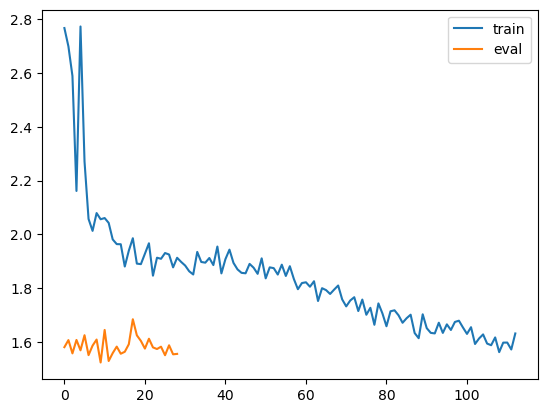

100%|██████████| 29/29 [00:05<00:00,  4.86it/s]

Epoch: 2
Train Loss: 1.514 | Train Accuracy: 47.49%
Eval Loss: 1.453 | Eval Accuracy: 49.15%
----------


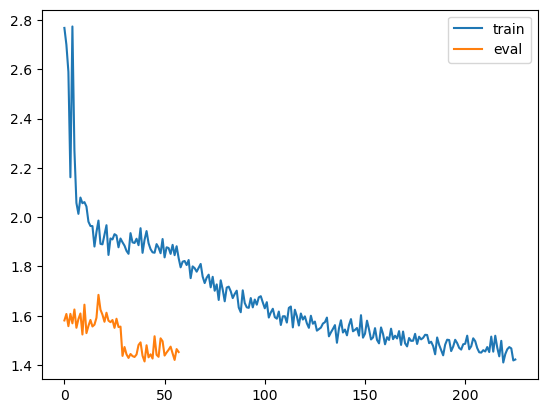

100%|██████████| 29/29 [00:06<00:00,  4.69it/s]

Epoch: 3
Train Loss: 1.399 | Train Accuracy: 51.05%
Eval Loss: 1.339 | Eval Accuracy: 52.78%
----------


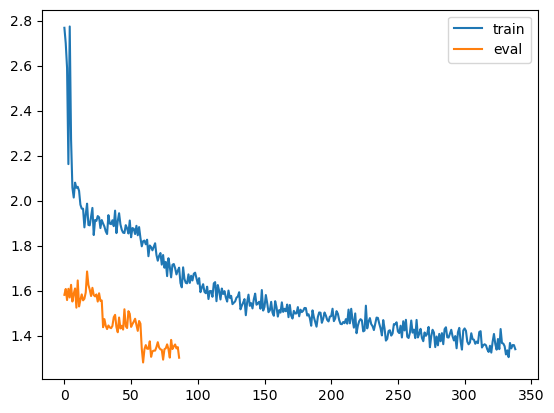

100%|██████████| 29/29 [00:05<00:00,  4.90it/s]

Epoch: 4
Train Loss: 1.304 | Train Accuracy: 54.44%
Eval Loss: 1.260 | Eval Accuracy: 55.73%
----------


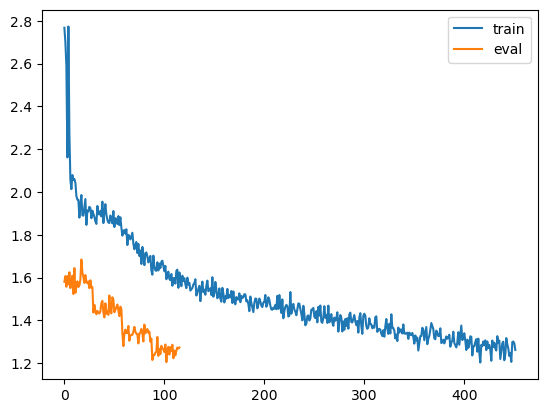

100%|██████████| 29/29 [00:06<00:00,  4.61it/s]

Epoch: 5
Train Loss: 1.217 | Train Accuracy: 57.68%
Eval Loss: 1.209 | Eval Accuracy: 57.57%
----------


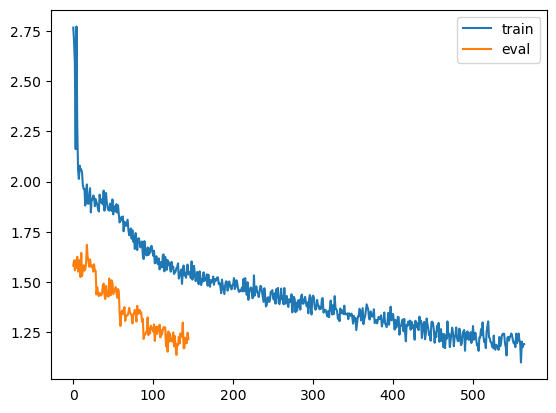

100%|██████████| 29/29 [00:06<00:00,  4.83it/s]

Epoch: 6
Train Loss: 1.146 | Train Accuracy: 60.22%
Eval Loss: 1.174 | Eval Accuracy: 59.03%
----------


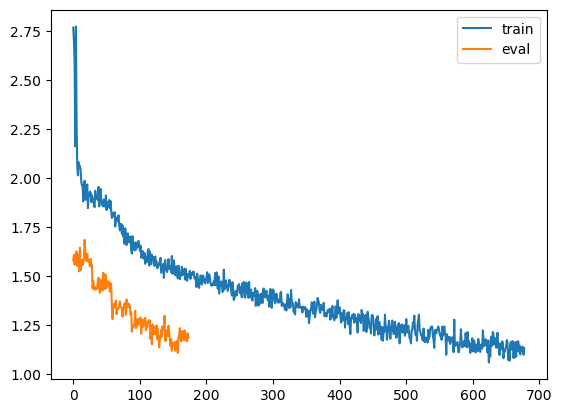

100%|██████████| 29/29 [00:05<00:00,  4.86it/s]

Epoch: 7
Train Loss: 1.074 | Train Accuracy: 62.92%
Eval Loss: 1.149 | Eval Accuracy: 60.30%
----------


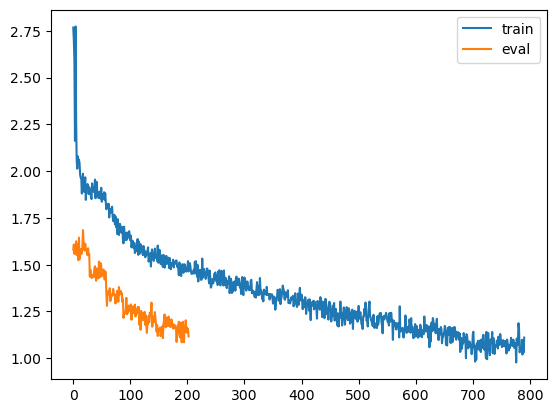

100%|██████████| 29/29 [00:06<00:00,  4.76it/s]

Epoch: 8
Train Loss: 0.995 | Train Accuracy: 65.55%
Eval Loss: 1.152 | Eval Accuracy: 60.83%
----------


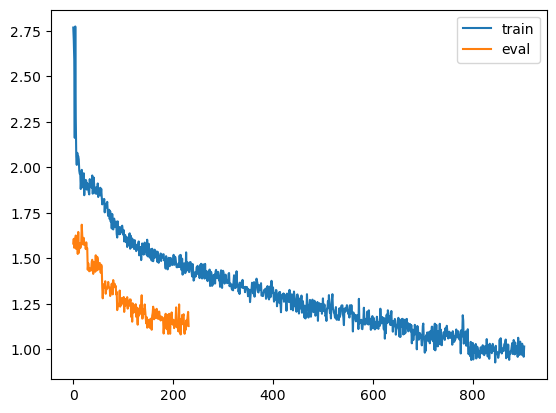

100%|██████████| 29/29 [00:06<00:00,  4.76it/s]

Epoch: 9
Train Loss: 0.903 | Train Accuracy: 68.97%
Eval Loss: 1.164 | Eval Accuracy: 61.09%
----------


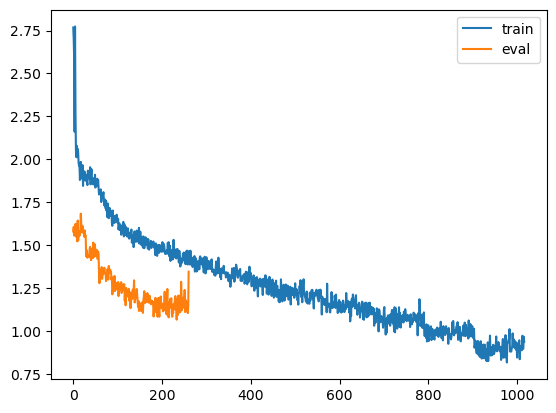

100%|██████████| 29/29 [00:06<00:00,  4.62it/s]

Epoch: 10
Train Loss: 0.801 | Train Accuracy: 72.52%
Eval Loss: 1.220 | Eval Accuracy: 60.58%
----------


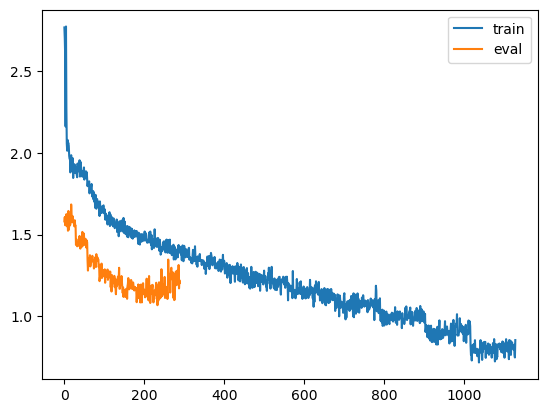

Model saved successfully!
Model loss history saved successfully!


In [62]:
# Define train method
import pickle

# Hyperparameters
char_vocab_size = alephbert_tokenizer.vocab_size
char_embedding_dim = 32
word_hidden_dim = 16
char_hidden_dim = 512
num_labels = len(label_to_id)

# Model, Criterion, Optimizer
reading_direction_model = ReadingDirectionModel(char_vocab_size, num_labels, char_embedding_dim=char_embedding_dim, word_hidden_dim=word_hidden_dim, char_hidden_dim=char_hidden_dim).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=len(label_to_id)).to(device)
optimizer = optim.Adam(reading_direction_model.parameters(), lr=0.001)

# Training loop
train_directional_model_loss_history = []
val_directional_model_loss_history = []
# check if model is already trained
if os.path.exists('directional_model_10_epoch.pt') and False:
    reading_direction_model.load_state_dict(torch.load('directional_model_10_epoch.pt'))
    print('Model loaded successfully!')
    with open('directional_model_10_epoch_loss_history.pkl', 'rb') as f:
        train_directional_model_loss_history, val_directional_model_loss_history = pickle.load(f)
    print('Model loss history loaded successfully!')
else:
    for epoch in range(10):
        train_loss, train_accuracy = train_directional_model(reading_direction_model, train_loader, optimizer, criterion, train_directional_model_loss_history)
        eval_loss, eval_accuracy = evaluate_directional_model(reading_direction_model, val_loader, criterion, val_directional_model_loss_history)
        print(f'Epoch: {epoch+1}')
        print(f'Train Loss: {train_loss:.3f} | Train Accuracy: {train_accuracy*100:.2f}%')
        print(f'Eval Loss: {eval_loss:.3f} | Eval Accuracy: {eval_accuracy*100:.2f}%')
        print('-'*10)
        # plot train and eval loss
        plt.plot(train_directional_model_loss_history, label='train')
        plt.plot(val_directional_model_loss_history, label='eval')
        plt.legend()
        plt.show()

    # save 10 epoch lasm_model
    torch.save(reading_direction_model.state_dict(), 'directional_model_10_epoch.pt')
    print('Model saved successfully!')
    # save 10 epoch lasm_model_loss_history
    with open('directional_model_10_epoch_loss_history.pkl', 'wb') as f:
        pickle.dump([train_directional_model_loss_history, val_directional_model_loss_history], f)
    print('Model loss history saved successfully!')

In [ ]:
# only train without reseting the model

# for epoch in range(10):
#     train_loss, train_accuracy = train_lstm(reading_direction_model, train_loader, optimizer, criterion, train_lstm_loss_history)
#     eval_loss, eval_accuracy = evaluate_lstm(reading_direction_model, val_loader, criterion, val_lstm_loss_history)
#     print(f'Epoch: {epoch+1:02}')
#     print(f'Train Loss: {train_loss:.3f} | Train Accuracy: {train_accuracy*100:.2f}%')
#     print(f'Eval Loss: {eval_loss:.3f} | Eval Accuracy: {eval_accuracy*100:.2f}%')
#     print('-'*10)
#     # plot train and eval loss
#     plt.plot(train_lstm_loss_history, label='train')
#     plt.plot(val_lstm_loss_history, label='eval')
#     plt.legend()
#     plt.show()

In [ ]:
for batch in tqdm(test_loader):
    # predict on the first batch of the test set
    reading_direction_model.eval()
    with torch.no_grad():
        input_ids = batch['input_ids'].to(device)
        labels = batch['nikud'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        word_indices = batch['word_indices'].to(device)
        
        # print some information about the batch
        print("number of zeros in input_ids: ", torch.sum(input_ids == 0))
        print("number of 0 in attention_mask: ", torch.sum(attention_mask == 0))
        print("number of paddings in labels: ", torch.sum(labels == len(id_to_label)))

        # convert the input_ids to tokens
        tokens = alephbert_tokenizer.convert_ids_to_tokens(input_ids[0])
        # enumerate the tokens and their ids and save them in a dictionary
        token_ids = {i: token for i, token in enumerate(zip(input_ids[0].tolist(), tokens))}
        # save token_ids in a dataframe
        token_ids_df = pd.DataFrame.from_dict(token_ids, orient='index', columns=['id', 'token'])
        # add the labels to the dataframe
        token_ids_df['label'] = labels[0].tolist()
        
        # get the model's predictions and calculate the loss
        predictions = reading_direction_model.forward(input_ids, word_indices)
        predictions = predictions.view(-1, predictions.shape[-1])
        labels = labels.view(-1)
        loss = criterion(predictions, labels)
        
        # print some information about the predictions
        print("input_ids: ", input_ids)
        print("labels: ", labels)
        print("attention_mask: ", attention_mask)
        print(f'Predictions shape: {predictions.shape}')
        print("predictions: ", predictions)
        print(f'Loss: {loss.item():.4f}')
        
        # remove the padding tokens from the predictions and labels
        predictions = predictions[attention_mask.view(-1) == 1]
        labels = labels[attention_mask.view(-1) == 1]
        print(f'Predictions shape: {predictions.shape}')
        print(f'Labels shape: {labels.shape}')
        
        # get the top 2 predictions for each token
        predictions = torch.topk(predictions, k=2, dim=1).indices
        first_prediction = predictions[:, 0]
        second_prediction = predictions[:, 1]

        # calculate the accuracy of the model's predictions
        correct_sum = 0
        overall_sum = 0
        for i in range(len(first_prediction)):
            if first_prediction[i] != 0:
                overall_sum += 1
                if first_prediction[i] == labels[i]:
                    correct_sum += 1
        accuracy = correct_sum / overall_sum
        print(f'Accuracy of actual nikud: {accuracy:.4f}')
        
        overall_sum = torch.sum(first_prediction == labels)# + torch.sum(second_prediction == labels)
        
        # calculate the overall accuracy of the model's predictions
        accuracy = overall_sum / len(labels)
        print(f'Accuracy: {accuracy.item():.4f}')
        
        # print the model's predictions and the actual labels for the first 50 tokens
        print("Predictions\tLabels\t\tFirst\t\tSecond\t\tChar")
        for i in range(50):
            if token_ids_df.iloc[i]["token"] == '[PAD]':
                break
            if predictions[i][0] != 0:
                print(f'{predictions[i].tolist()}\t\t{labels[i]}\t\t{predictions[i].tolist()[0] == labels[i]}\t\t{predictions[i].tolist()[1] == labels[i]}\t\t{token_ids_df.iloc[i]["token"]}')
        break

# Models analysis functions

In [ ]:
def plot_confusion_matrix(actuals, predictions, labels):
    """
    Plot a confusion matrix for the model's predictions.
    """
    cm = confusion_matrix(actuals, predictions, labels=labels)
    # cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    epsilon = 1e-8
    cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + epsilon)
    cm[np.isnan(cm)] = 0
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels, fmt='.2f')
    # sns.heathamap
    plt.xlabel("True label")
    plt.ylabel("Predicted label")
    plt.show()

def convert_labels_to_names(label_to_id, actuals, predictions):
    """
    Convert the labels to their names.
    """
    nikud_dict = { 'ְ' : 'Sheva', 'ֱ' : 'Hataf Segol', 'ֲ' : 'Hataf Patah', 'ֳ' : 'Hataf Qamats', 'ִ' : 'Hiriq', 'ֵ' : 'Tseri', 'ֶ' : 'Segol', 'ַ' : 'Patah', 'ָ' : 'Qamats', 'ֹ' : 'Holam', 'ֻ' : 'Qubuts', 'ּ' : 'Dagesh', 'ֽ' : 'Siluk', '־' : 'Maqaf', 'ֿ' : 'Rafe', 'ׁ' : 'Shin Dot', 'ׂ' : 'Sin Dot', 'ׄ' : 'Upper Dot', 'ׅ' : 'Lower Dot', 'ׇ' : 'Point Meteg', 'װ' : 'Yiddish Double Vav', 'ױ' : 'Yiddish Vav Yod', 'ײ' : 'Yiddish Double Yod', '׳' : 'Geresh', '״' : 'Gershayim'}
    labels = list(label_to_id.keys())
    label_names = {'<no_nikud>': 'No Nikud'}
    for label in labels:
        if label == '<no_nikud>':
            continue
        label_name = []
        for char in label:
            label_name.append(nikud_dict[char])
        label_names[label] = ' '.join(label_name)
    actuals = [label_names[label] for label in actuals]
    predictions = [label_names[label] for label in predictions]
    return label_names, actuals, predictions

## Analysis of Reading Direction Model

100%|██████████| 16/16 [00:04<00:00,  3.97it/s]


Words:  [4, 4, 4, 5, 5, 4, 4, 5, 3, 3, 2, 3, 6, 6, 5, 3, 3, 5, 4, 5, 5, 4, 4, 4, 4, 3, 4, 5, 3, 5, 3, 4, 2, 4, 3, 2, 5, 3, 2, 5, 2, 4, 6, 5, 2, 3, 4, 3, 3, 5, 5, 5, 8, 5, 8, 6, 4, 4, 4, 4, 6, 3, 6, 4, 3, 3, 6, 3, 5, 4, 3, 5, 5, 3, 2, 5, 6, 2, 4, 4, 1, 4, 3, 4, 2, 5, 4, 5, 2, 2, 4, 2, 3, 3, 4, 4, 4, 4, 3, 5, 4, 3, 5, 3, 6, 3, 6, 5, 4, 4, 5, 3, 4, 3, 4, 4, 2, 4, 3, 4, 2, 2, 5, 2, 3, 6, 4, 4, 5, 6, 5, 2, 6, 2, 5, 4, 2, 3, 2, 6, 3, 7, 1, 3, 5, 3, 4, 2, 3, 5, 5, 5, 7, 7, 3, 4, 3, 4, 5, 3, 3, 2, 6, 2, 5, 3, 3, 4, 7, 3, 5, 6, 4, 4, 4, 4, 5, 4, 4, 4, 6, 3, 4, 5, 6, 4, 5, 6, 4, 5, 6, 2, 6, 5, 6, 3, 3, 6, 4, 5, 2, 5, 3, 4, 4, 2, 5, 4, 3, 5, 5, 3, 3, 3, 6, 6, 2, 2, 5, 4, 4, 4, 4, 3, 2, 5, 5, 4, 4, 2, 4, 4, 3, 4, 5, 4, 5, 3, 4, 5, 2, 5, 3, 4, 4, 3, 2, 2, 5, 3, 4, 2, 2, 7, 3, 5, 6, 5, 4, 5, 5, 5, 5, 3, 5, 2, 5, 3, 3, 3, 4, 3, 5, 3, 3, 7, 8, 2, 4, 6, 7, 4, 6, 5, 6, 2, 3, 6, 6, 5, 5, 1, 2, 2, 5, 4, 5, 3, 5, 7, 4, 5, 5, 5, 4, 3, 4, 2, 4, 2, 6, 4, 4, 3, 5, 2, 5, 6, 4, 4, 3, 5, 4, 2, 4, 2, 3, 5, 2, 4, 2

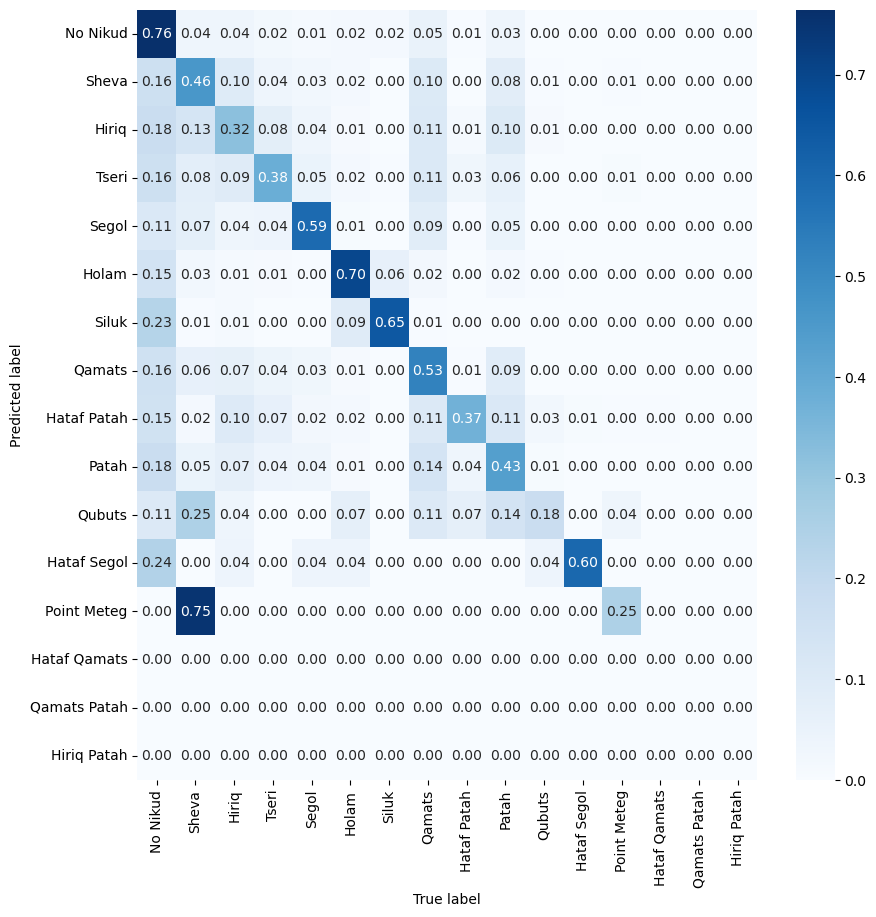

In [80]:
# get predictions for the test set
actuals, predictions, words = predict_directional_model(reading_direction_model, test_loader)
print("Words: ", words)
# convert the actual labels and the predictions to lists
actuals = [id_to_label[label.item()] for label in actuals]
predictions = [id_to_label[label.item()] for label in predictions]
# convert the labels to names
label_names, actuals, predictions = convert_labels_to_names(label_to_id, actuals, predictions)
plot_confusion_matrix(actuals, predictions, list(label_names.values()))

# Define the dual model class, it will be composed of two models.
#### whenever there is a disagreement between the two models, the model will add nikud using the lookahead model

## Evaluation of the dual model